<p style="font-size: 18px;">
  This is the accompanying code for the post titled "Mastering Hyperparameter Optimization: Unlocking the Full Potential of Supervised Learning Models with Code"<br>
  You can find it <a href="https://pureai.substack.com/p/mastering-hyperparameter-optimization">here</a>.<br>
  Published: October 20, 2023<br>
  <a href="https://pureai.substack.com">https://pureai.substack.com</a>
</p>

Welcome to this Jupyter notebook! If you're new to Python or don't have it installed on your system, don't worry; you can still follow along and explore the code.

Here's a quick guide to getting started:

- Using an Online Platform: You can run this notebook in a web browser using platforms like Google Colab or Binder. These services offer free access to Jupyter notebooks and don't require any installation.
- Installing Python Locally: If you'd prefer to run this notebook on your own machine, you'll need to install Python. A popular distribution for scientific computing is Anaconda, which includes Python, Jupyter, and other useful tools.
  - Download Anaconda from [here](https://www.anaconda.com/download).
  - Follow the installation instructions for your operating system.
  - Launch Jupyter Notebook from Anaconda Navigator or by typing jupyter notebook in your command line or terminal.
- Opening the Notebook: Once you have Jupyter running, navigate to the location of this notebook file (.ipynb) and click on it to open.
- Running the Code: You can run each cell in the notebook by selecting it and pressing Shift + Enter. Feel free to modify the code and experiment with it.
- Need More Help?: If you're new to Python or Jupyter notebooks, you might find these resources helpful:
  - [Python.org's Beginner's Guide](https://docs.python.org/3/tutorial/index.html)
  - [Jupyter Notebook Basics](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Notebook%20Basics.html)

Happy coding, and enjoy exploring the fascinating world of Hyperparameter Tuning!

### Bayesian Hyperparameter Optimization

As we covered in the post, Bayesian Optimization is a probabilistic model-based optimization technique aimed at finding the minimum of any function that returns a real-value metric. It is particularly well-suited for optimizing complex, high-dimensional functions that are expensive to evaluate. In machine learning, it can be used for hyperparameter tuning, effectively replacing grid search and random search methods. Today, we'll see how to apply Bayesian Optimization to optimize the hyperparameters of a RandomForestClassifier using the bayes_opt library.

### The Setup

First, let's complete the code setup. We have the run_classifier function, which takes in a classifier and returns the mean and standard deviation of accuracy, as well as the mean True Positive Rate (TPR) and False Positive Rate (FPR). This function uses 10-fold stratified cross-validation.

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np

bop_log = []

def run_classifier(classifier, log_progress=False):
    global feature_data, target_data, bop_log
    X_data, y_data = feature_data, target_data
    true_positive_rates = []
    false_positive_rates = []
    accuracies = []
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    
    for train_indices, test_indices in kfold.split(X_data, y_data):
        classifier.fit(X_data[train_indices], y_data[train_indices])
        y_predicted = classifier.predict(X_data[test_indices])
        
        acc = accuracy_score(y_data[test_indices], y_predicted)
        accuracies.append(acc)
        
        tn, fp, fn, tp = confusion_matrix(y_data[test_indices], y_predicted, labels=[1, 0]).ravel()
        
        true_positive_rate = tp / (tp + fn)
        false_positive_rate = fp / (fp + tn)
        
        true_positive_rates.append(true_positive_rate)
        false_positive_rates.append(false_positive_rate)
        
    mean_tpr = np.mean(true_positive_rates)
    mean_fpr = np.mean(false_positive_rates)
    
    if log_progress:
        bop_log.append((mean_tpr, mean_fpr))
        
    return np.mean(accuracies), np.std(accuracies), mean_tpr, mean_fpr

The costf function is our objective function that we aim to maximize. It takes in hyperparameters for the Random Forest Classifier and returns the cost.

In [2]:
from bayes_opt import BayesianOptimization

def avg(_x):
    return (_x[0]+_x[1])/2.

def costf(_X):  # BOP maximizes
    def costf(_pd, _pf):
        return 5*(1.-_pd)+_pf

    S = _X.shape[0]  # number of particles
    costs = np.ones((S,), dtype=float)

    for i in range(S):
        hp = np.array(_X[i], int)  # hyperparameters are integers
        clf = RandomForestClassifier(n_estimators=hp[0], max_depth=hp[1], max_features=hp[2], n_jobs=-1)
        acc, std, tpr, fpr = run_classifier(clf, True)
        costs[i] = costf(tpr, fpr)

    return costs

Let's start by creating some random test data (X_train, y_train) that we'll use for our example.

In [3]:
from sklearn.datasets import make_classification

# Create random data
feature_data, target_data = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5)

Define Hyperparameter Bounds

Before we run the Bayesian Optimization, let's set the bounds for the hyperparameters we are interested in tuning. For the Random Forest Classifier, we'll be tuning:
- Number of estimators (ne)
- Maximum depth (md)
- Maximum features (mf)

In [4]:
# Define the bounds for the hyperparameters
N_ESTIM = (10, 100)
MAX_DEP = (1, 10)
MAX_FEA = (1, 5)

pbounds = {'ne': N_ESTIM, 'md': MAX_DEP, 'mf': MAX_FEA}

### The Objective Function for Bayesian Optimization

The function costf_bop is what the Bayesian Optimization will maximize. It's a wrapper around costf, converting the hyperparameters and preparing them for costf.

In [5]:
def costf_bop(ne, md, mf):  # Bayesian Op maximizes
    cost = costf(np.array([ne, md, mf]).reshape(-1, 3))
    return -cost[0]

### Running the Bayesian Optimization

Now, let's set up and run the Bayesian Optimization.

In [6]:
from bayes_opt import BayesianOptimization

# Initialize Bayesian Optimization
boptim = BayesianOptimization(
    f=costf_bop,
    pbounds=pbounds,
    random_state=0,
)

PSO_ITERS_N = 20  # Number of iterations
bop_log = []  # collect Pd Pf

# Run the optimizer
boptim.maximize(init_points=3, n_iter=PSO_ITERS_N)

|   iter    |  target   |    md     |    mf     |    ne     |
-------------------------------------------------------------
| 1         | -0.7926   | 5.939     | 3.861     | 64.25     |
| 2         | -0.7781   | 5.904     | 2.695     | 68.13     |
| 3         | -0.9731   | 4.938     | 4.567     | 96.73     |
| 4         | -1.76     | 1.32      | 1.109     | 21.54     |
| 5         | -1.548    | 1.0       | 5.0       | 78.03     |
| 6         | -0.6331   | 10.0      | 1.0       | 54.49     |
| 7         | -1.53     | 1.0       | 1.0       | 49.95     |
| 8         | -0.6466   | 9.7       | 1.209     | 60.58     |
| 9         | -0.6664   | 10.0      | 5.0       | 40.39     |
| 10        | -0.7405   | 9.974     | 4.685     | 32.62     |
| 11        | -1.413    | 1.941     | 5.0       | 36.5      |
| 12        | -0.6325   | 9.981     | 4.906     | 48.29     |
| 13        | -0.8166   | 10.0      | 5.0       | 10.0      |
| 14        | -0.6245   | 10.0      | 5.0       | 56.52     |
| 15    

### Results and Best Parameters

After the optimization is complete, let's look at the best parameters and costs.

In [7]:
print(f"cost= {boptim.max['target']:.3f}")
bop_op_params = [int(boptim.max['params']['ne']), int(boptim.max['params']['md']), int(boptim.max['params']['mf'])]
print(f"OP params= {bop_op_params}")

# best OP
_, _, bop_tpr, bop_fpr = run_classifier(
    RandomForestClassifier(n_estimators=bop_op_params[0],
                           max_depth=bop_op_params[1], max_features=bop_op_params[2], n_jobs=-1))

Fpr1, Tpr1 = [_[1] for _ in bop_log], [_[0] for _ in bop_log]
Std1 = 0.02*np.ones((len(Tpr1),), dtype=float)

cost= -0.567
OP params= [100, 10, 1]


### ROC Curve

Finally, let's plot the Receiver Operating Characteristic (ROC) curve to visualize the performance.

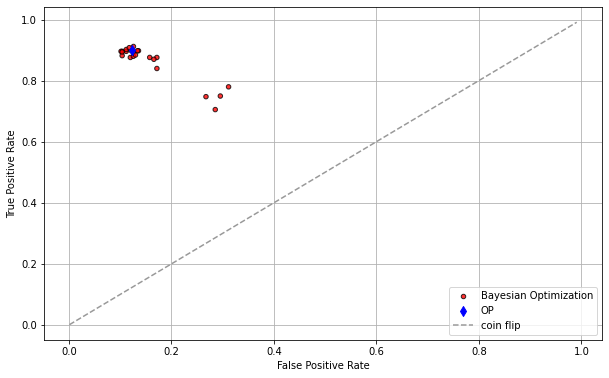

In [8]:
import matplotlib.pyplot as plt

def plotr(_ax, _fpr, _tpr, _std0, _label, op=None):
    _ax.scatter(_fpr, _tpr, s=_std0 * 1000, marker='o', c='r', edgecolors='k', alpha=0.8, label=_label)
    if op is not None:
        _ax.scatter(op[0], op[1], s=50, marker='d', c='b', label='OP')
    _ax.plot(np.arange(0.001,1,0.01), np.arange(0.001,1,0.01), linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
    _ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    _ax.grid()
    _ax.legend()

_, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=72)

Fpr1, Tpr1 = [_[1] for _ in bop_log], [_[0] for _ in bop_log]
Std1 = 0.02*np.ones((len(Tpr1),), dtype=float)

plotr(ax, Fpr1, Tpr1, Std1, 'Bayesian Optimization', op=(bop_fpr, bop_tpr))

plt.show()

And there you have it! This is a simple but effective demonstration of how Bayesian Optimization can be applied for hyperparameter tuning in machine learning models. Happy tuning!